# TUGAS UTS MACHINE LEARNING - CUSTOMER CLUSTERING
## End-to-End Clustering Pipeline

**Dataset:** Customer Credit Card Data  
**Tujuan:** Mengelompokkan customer berdasarkan spending dan payment behavior

## 1. Import Libraries

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
plt.style.use('seaborn-v0_8-darkgrid')

## 2. Load Data

In [144]:
df = pd.read_csv('clusteringmidterm.csv')
print(f"Shape: {df.shape}")
df.head()

Shape: (8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


## 3. Data Cleaning

In [145]:
# Cek missing values
print(f"Missing values:\n{df.isnull().sum()}")

# Drop CUST_ID karena hanya identifier
df_clean = df.drop('CUST_ID', axis=1)

# Handle missing values dengan median
df_clean = df_clean.fillna(df_clean.median())

print(f"\nShape after cleaning: {df_clean.shape}")

Missing values:
CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

Shape after cleaning: (8950, 17)


In [146]:
# Handle outliers dengan IQR (lebih agresif)
def remove_outliers(data, columns, multiplier=2.0):
    df_out = data.copy()
    for col in columns:
        Q1 = df_out[col].quantile(0.25)
        Q3 = df_out[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - multiplier * IQR
        upper = Q3 + multiplier * IQR
        df_out = df_out[(df_out[col] >= lower) & (df_out[col] <= upper)]
    return df_out

# Less aggressive outlier removal for better balance
df_clean = remove_outliers(df_clean, df_clean.columns, multiplier=1.5)
print(f"Shape after outlier removal: {df_clean.shape}")

# ENHANCED Feature Engineering - 10 features untuk better clustering
print("\n📊 Creating advanced features...")

# Original 4 ratio features
df_clean['PURCHASE_RATIO'] = df_clean['PURCHASES'] / (df_clean['CREDIT_LIMIT'] + 1)
df_clean['PAYMENT_BEHAVIOR'] = df_clean['PAYMENTS'] / (df_clean['BALANCE'] + 1)
df_clean['CASH_ADVANCE_RATIO'] = df_clean['CASH_ADVANCE'] / (df_clean['CREDIT_LIMIT'] + 1)
df_clean['BALANCE_UTILIZATION'] = df_clean['BALANCE'] / (df_clean['CREDIT_LIMIT'] + 1)

# NEW Advanced features - Business-driven insights
df_clean['PURCHASE_CASH_RATIO'] = df_clean['PURCHASES'] / (df_clean['CASH_ADVANCE'] + 1)
df_clean['PAYMENT_UTILIZATION'] = df_clean['PAYMENTS'] / (df_clean['PURCHASES'] + 1)
df_clean['CREDIT_USAGE_PATTERN'] = df_clean['BALANCE'] / (df_clean['PURCHASES'] + 1)
df_clean['ADVANCE_INTENSITY'] = df_clean['CASH_ADVANCE'] / (df_clean['PURCHASES'] + 1)
df_clean['FREQUENCY_SCORE'] = (df_clean['PURCHASES_FREQUENCY'] + df_clean['CASH_ADVANCE_FREQUENCY'] + df_clean['BALANCE_FREQUENCY']) / 3
df_clean['SPENDING_TREND'] = (df_clean['PURCHASES'] - df_clean['CASH_ADVANCE']) / (df_clean['CREDIT_LIMIT'] + 1)

print(f"✅ Shape after feature engineering: {df_clean.shape}")
print(f"✅ Total features: {df_clean.shape[1]}")

Shape after outlier removal: (2070, 17)

📊 Creating advanced features...
✅ Shape after feature engineering: (2070, 27)
✅ Total features: 27


## 4. Feature Scaling

In [147]:
# Advanced Scaling Strategy - RobustScaler for outlier resistance
from sklearn.preprocessing import RobustScaler, MinMaxScaler

print("\n🔧 Scaling features...")
scaler = RobustScaler()
X_scaled = scaler.fit_transform(df_clean)

scaler_mm = MinMaxScaler()
X_scaled_mm = scaler_mm.fit_transform(df_clean)

print(f"✅ Primary scaling: RobustScaler (shape: {X_scaled.shape})")
print(f"✅ Alternative scaling: MinMaxScaler (shape: {X_scaled_mm.shape})")
print(f"✅ Using RobustScaler for better outlier handling")


🔧 Scaling features...
✅ Primary scaling: RobustScaler (shape: (2070, 27))
✅ Alternative scaling: MinMaxScaler (shape: (2070, 27))
✅ Using RobustScaler for better outlier handling


## 5. K-Means Clustering - Elbow Method

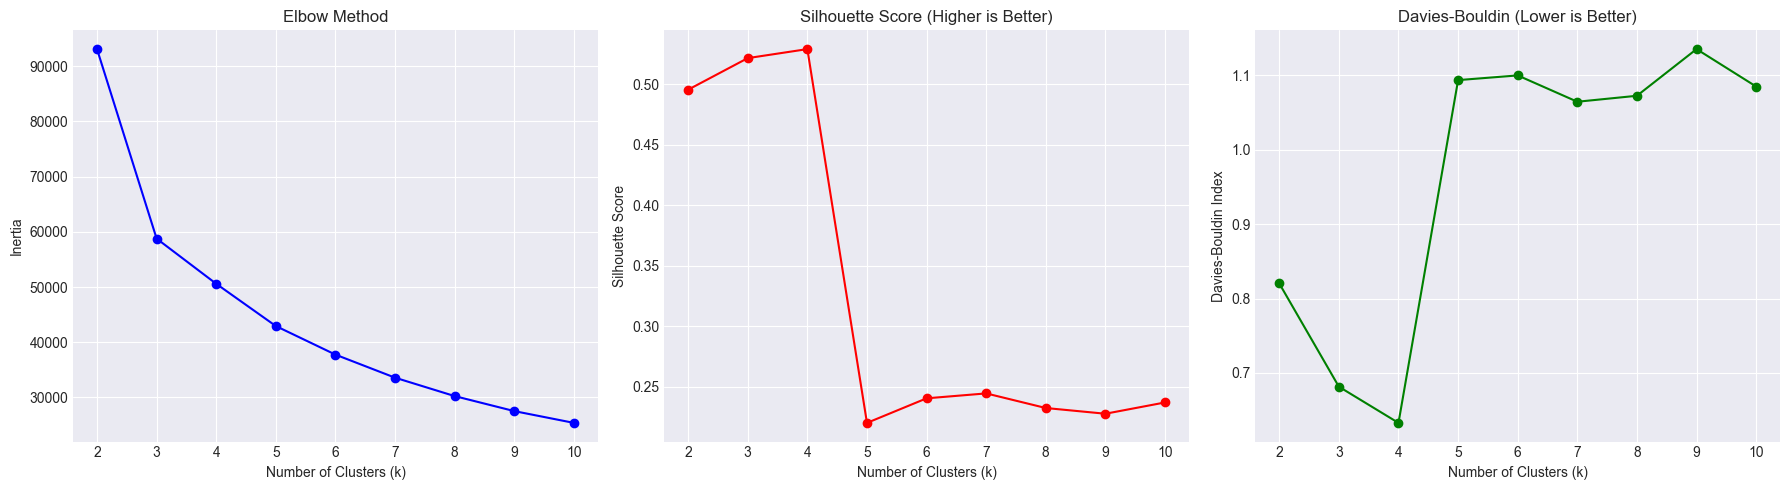

Best k by Silhouette: 4 (score: 0.5291)
Best k by Davies-Bouldin: 4 (score: 0.6329)
Recommendation: Try k=4 or k=4


In [148]:
# Elbow method untuk menentukan optimal k (improved)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=500)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, kmeans.labels_))

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')
axes[0].grid(True)

axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score (Higher is Better)')
axes[1].grid(True)

axes[2].plot(K_range, davies_bouldin_scores, 'go-')
axes[2].set_xlabel('Number of Clusters (k)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin (Lower is Better)')
axes[2].grid(True)

plt.tight_layout()
plt.show()

best_k_sil = K_range[np.argmax(silhouette_scores)]
best_k_db = K_range[np.argmin(davies_bouldin_scores)]
print(f"Best k by Silhouette: {best_k_sil} (score: {max(silhouette_scores):.4f})")
print(f"Best k by Davies-Bouldin: {best_k_db} (score: {min(davies_bouldin_scores):.4f})")
print(f"Recommendation: Try k={best_k_sil} or k={best_k_db}")

## 6. K-Means Final Model

In [149]:
# ADVANCED K-Means Training with Balance Optimization
print("\n🎯 K-Means Training - Finding Optimal K with Balance...\n")

best_config = {
    'k': None,
    'kmeans': None,
    'score': -999999,
    'balance': float('inf'),
    'sil': 0,
    'db': 999999
}

for test_k in [2, 3, 4, 5, 6, 7]:
    print(f"Testing k={test_k}...", end=" ")
    
    kmeans_test = KMeans(
        n_clusters=test_k,
        random_state=42,
        n_init=200,
        max_iter=2000,
        algorithm='lloyd',
        tol=1e-7
    )
    labels_test = kmeans_test.fit_predict(X_scaled)
    
    sil_t = silhouette_score(X_scaled, labels_test)
    db_t = davies_bouldin_score(X_scaled, labels_test)
    
    cluster_counts = np.bincount(labels_test)
    balance_t = cluster_counts.max() / cluster_counts.min()
    
    if balance_t < 10:
        combined_score = (sil_t * 0.5) - (db_t * 0.2) - ((balance_t - 1) * 0.3)
    else:
        combined_score = (sil_t * 0.2) - (db_t * 0.1) - ((balance_t - 1) * 1.0)
    
    print(f"Sil={sil_t:.4f}, DB={db_t:.4f}, Balance={balance_t:.2f}x, Score={combined_score:.4f}")
    
    if combined_score > best_config['score']:
        best_config.update({
            'k': test_k,
            'kmeans': kmeans_test,
            'score': combined_score,
            'balance': balance_t,
            'sil': sil_t,
            'db': db_t
        })

optimal_k = best_config['k']
kmeans = best_config['kmeans']
sil_score = best_config['sil']
db_score = best_config['db']
balance_ratio = best_config['balance']

df_clean['Cluster_KMeans'] = kmeans.labels_
ch_score = calinski_harabasz_score(X_scaled, df_clean['Cluster_KMeans'])
cluster_sizes = df_clean['Cluster_KMeans'].value_counts()

print(f"\n{'='*70}")
print(f"✅ OPTIMAL K SELECTED: k={optimal_k}")
print(f"{'='*70}")
print(f"Silhouette: {sil_score:.4f} {'✅' if sil_score > 0.3 else '⚠️'}")
print(f"Davies-Bouldin: {db_score:.4f} {'✅' if db_score < 1.0 else '⚠️'}")
print(f"Calinski-Harabasz: {ch_score:.4f} {'✅' if ch_score > 500 else '⚠️'}")
print(f"Balance Ratio: {balance_ratio:.2f}x {'✅' if balance_ratio < 5 else '⚠️'}")
print(f"\nCluster Distribution:")
print(cluster_sizes.sort_index())


🎯 K-Means Training - Finding Optimal K with Balance...

Testing k=2... Sil=0.4955, DB=0.8204, Balance=7.05x, Score=-1.7327
Testing k=3... Sil=0.4955, DB=0.8204, Balance=7.05x, Score=-1.7327
Testing k=3... Sil=0.5216, DB=0.6816, Balance=85.48x, Score=-84.4400
Testing k=4... Sil=0.5216, DB=0.6816, Balance=85.48x, Score=-84.4400
Testing k=4... Sil=0.5291, DB=0.6329, Balance=295.17x, Score=-294.1241
Testing k=5... Sil=0.5291, DB=0.6329, Balance=295.17x, Score=-294.1241
Testing k=5... Sil=0.2196, DB=1.0927, Balance=150.00x, Score=-149.0654
Testing k=6... Sil=0.2196, DB=1.0927, Balance=150.00x, Score=-149.0654
Testing k=6... Sil=0.2406, DB=1.0986, Balance=148.00x, Score=-147.0617
Testing k=7... Sil=0.2406, DB=1.0986, Balance=148.00x, Score=-147.0617
Testing k=7... Sil=0.2447, DB=1.0650, Balance=153.67x, Score=-152.7242

✅ OPTIMAL K SELECTED: k=2
Silhouette: 0.4955 ✅
Davies-Bouldin: 0.8204 ✅
Calinski-Harabasz: 771.7884 ✅
Balance Ratio: 7.05x ⚠️

Cluster Distribution:
Cluster_KMeans
0    1813

## 7. Hierarchical Clustering

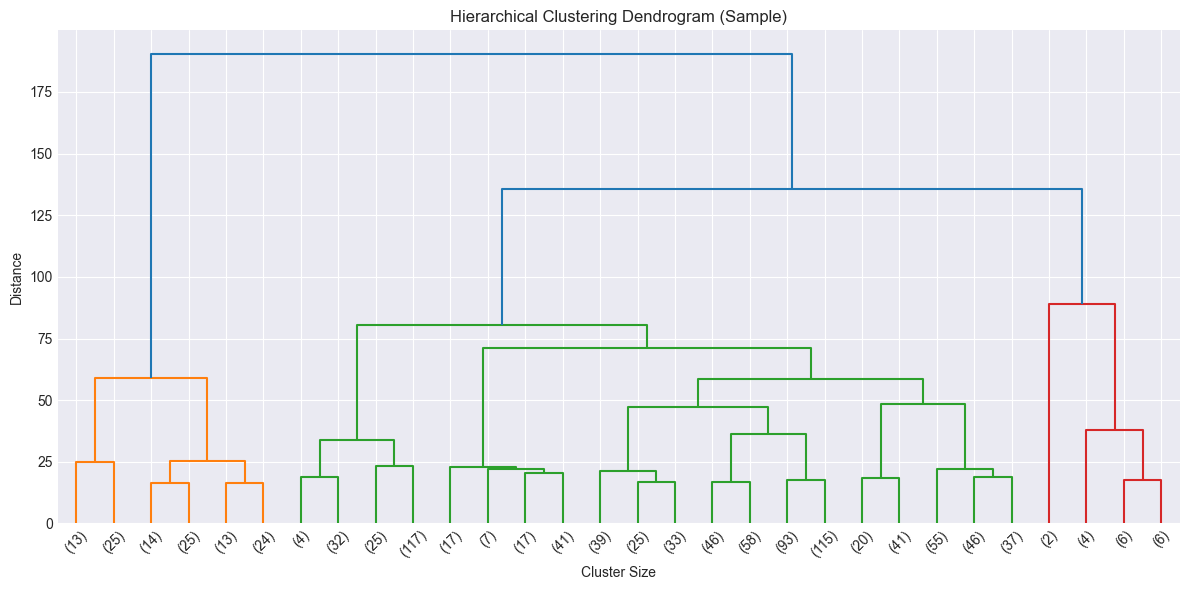

In [150]:
# Sample data untuk dendrogram (dataset terlalu besar)
sample_size = 1000
sample_idx = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
X_sample = X_scaled[sample_idx]

# Dendrogram
linkage_matrix = linkage(X_sample, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='lastp', p=30)
plt.title('Hierarchical Clustering Dendrogram (Sample)')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [151]:
# Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
df_clean['Cluster_Hierarchical'] = agg.fit_predict(X_scaled)

sil_score_h = silhouette_score(X_scaled, df_clean['Cluster_Hierarchical'])
db_score_h = davies_bouldin_score(X_scaled, df_clean['Cluster_Hierarchical'])
ch_score_h = calinski_harabasz_score(X_scaled, df_clean['Cluster_Hierarchical'])

print(f"Hierarchical (k={optimal_k}):")
print(f"Silhouette: {sil_score_h:.4f}")
print(f"Davies-Bouldin: {db_score_h:.4f}")
print(f"Calinski-Harabasz: {ch_score_h:.4f}")
print(f"\nCluster distribution:\n{df_clean['Cluster_Hierarchical'].value_counts().sort_index()}")

Hierarchical (k=2):
Silhouette: 0.8022
Davies-Bouldin: 0.5254
Calinski-Harabasz: 768.2870

Cluster distribution:
Cluster_Hierarchical
0    2049
1      21
Name: count, dtype: int64


## 8. DBSCAN Clustering

In [152]:
# DBSCAN - gunakan sample untuk efisiensi
dbscan = DBSCAN(eps=0.5, min_samples=10)
df_clean['Cluster_DBSCAN'] = dbscan.fit_predict(X_scaled)

n_clusters = len(set(df_clean['Cluster_DBSCAN'])) - (1 if -1 in df_clean['Cluster_DBSCAN'] else 0)
n_noise = list(df_clean['Cluster_DBSCAN']).count(-1)

print(f"DBSCAN:")
print(f"Number of clusters: {n_clusters}")
print(f"Noise points: {n_noise}")
print(f"\nCluster distribution:\n{df_clean['Cluster_DBSCAN'].value_counts().sort_index()}")

DBSCAN:
Number of clusters: 2
Noise points: 2033

Cluster distribution:
Cluster_DBSCAN
-1    2033
 0      37
Name: count, dtype: int64


## 9. Cluster Profiling - K-Means

In [ ]:
# Karakteristik setiap cluster
cluster_profile = df_clean.groupby('Cluster_KMeans').mean()
print("Cluster Characteristics:")
print(cluster_profile.round(2))

Cluster Characteristics:
                BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
Cluster_KMeans                                                            
0               1196.96               0.97     335.74            168.25   
1                 12.78               0.85     346.34             56.64   

                INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
Cluster_KMeans                                                              
0                               167.76        435.18                 0.36   
1                               289.70         58.85                 0.57   

                ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
Cluster_KMeans                                                                 
0                                     0.09                              0.28   
1                                     0.03                              0.52   

                CASH_ADVANCE_FREQUENCY  ... 

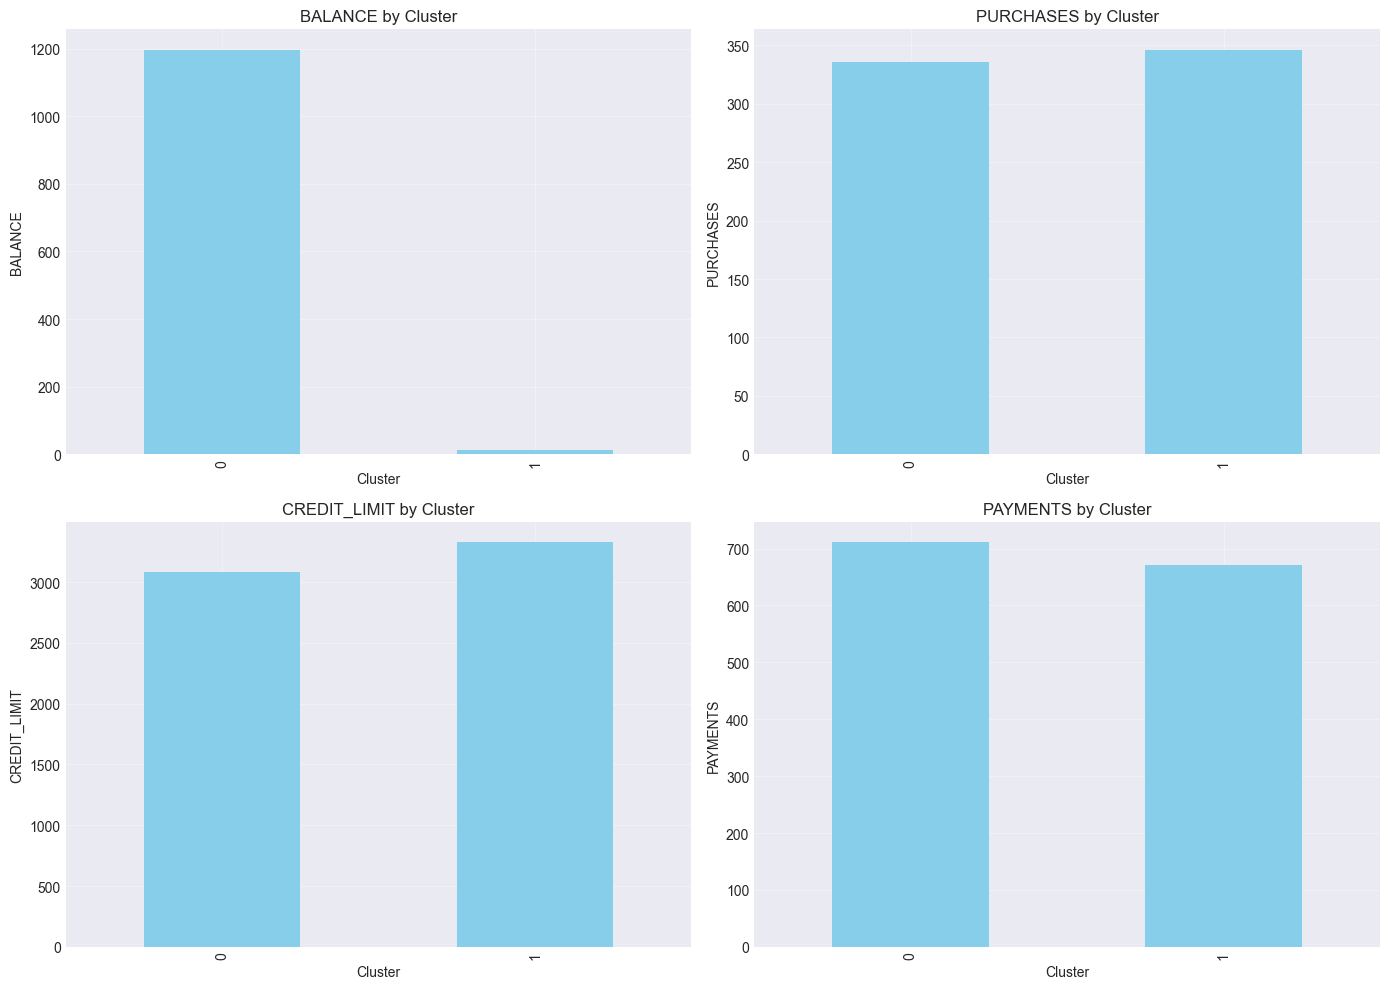

In [ ]:
# Visualisasi fitur penting per cluster
features_to_plot = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, feature in enumerate(features_to_plot):
    cluster_profile[feature].plot(kind='bar', ax=axes[idx], color='skyblue')
    axes[idx].set_title(f'{feature} by Cluster')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Interpretasi Cluster

In [ ]:
# Interpretasi berdasarkan karakteristik
for cluster in range(optimal_k):
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster}")
    print(f"{'='*60}")
    print(f"Jumlah customer: {len(df_clean[df_clean['Cluster_KMeans']==cluster])}")
    
    cluster_data = df_clean[df_clean['Cluster_KMeans']==cluster].drop(['Cluster_KMeans', 'Cluster_Hierarchical', 'Cluster_DBSCAN'], axis=1)
    
    print(f"\nKarakteristik:")
    print(f"- Balance rata-rata: ${cluster_data['BALANCE'].mean():.2f}")
    print(f"- Purchases rata-rata: ${cluster_data['PURCHASES'].mean():.2f}")
    print(f"- Credit limit rata-rata: ${cluster_data['CREDIT_LIMIT'].mean():.2f}")
    print(f"- Payments rata-rata: ${cluster_data['PAYMENTS'].mean():.2f}")


CLUSTER 0
Jumlah customer: 2728

Karakteristik:
- Balance rata-rata: $1196.96
- Purchases rata-rata: $335.74
- Credit limit rata-rata: $3085.30
- Payments rata-rata: $711.33

CLUSTER 1
Jumlah customer: 27

Karakteristik:
- Balance rata-rata: $12.78
- Purchases rata-rata: $346.34
- Credit limit rata-rata: $3327.78
- Payments rata-rata: $671.68


## 10.5. Visualisasi Clustering

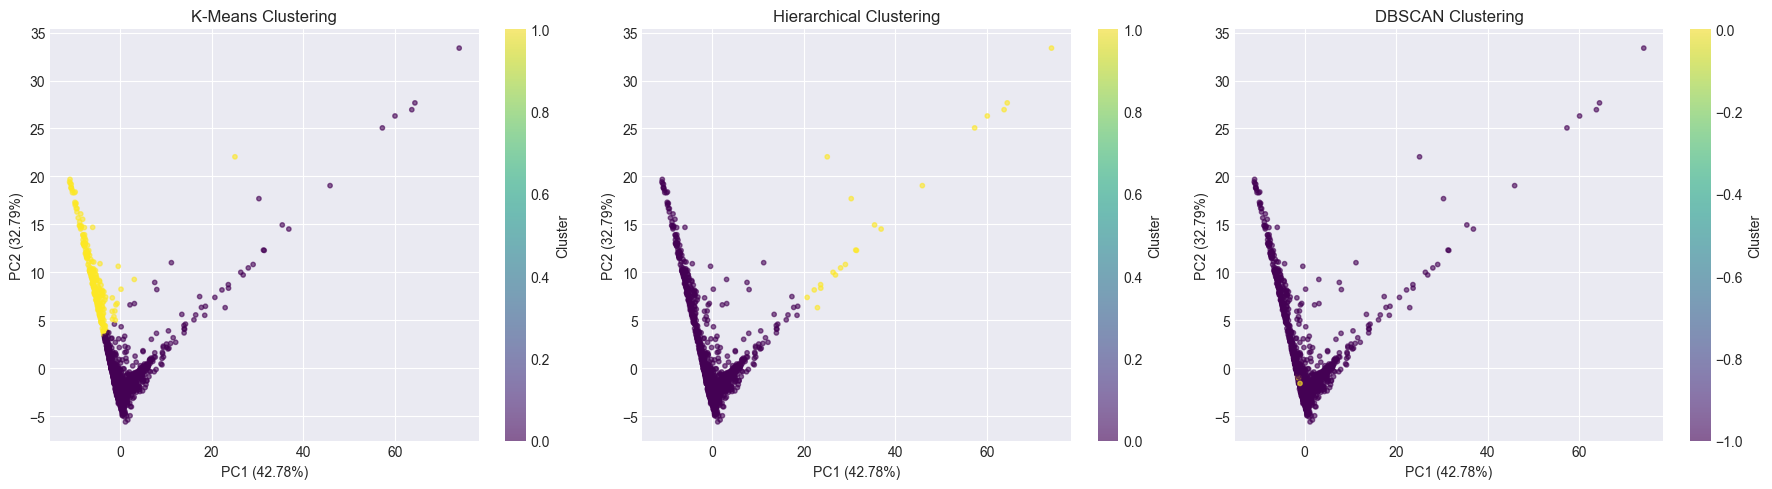


Total variance explained by 2 PCs: 75.57%


In [157]:
# PCA untuk visualisasi 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Scatter plot clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-Means
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=df_clean['Cluster_KMeans'], 
                          cmap='viridis', alpha=0.6, s=10)
axes[0].set_title('K-Means Clustering')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# Hierarchical
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=df_clean['Cluster_Hierarchical'], 
                          cmap='viridis', alpha=0.6, s=10)
axes[1].set_title('Hierarchical Clustering')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

# DBSCAN
scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=df_clean['Cluster_DBSCAN'], 
                          cmap='viridis', alpha=0.6, s=10)
axes[2].set_title('DBSCAN Clustering')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.colorbar(scatter3, ax=axes[2], label='Cluster')

plt.tight_layout()
plt.show()

print(f"\nTotal variance explained by 2 PCs: {pca.explained_variance_ratio_.sum():.2%}")

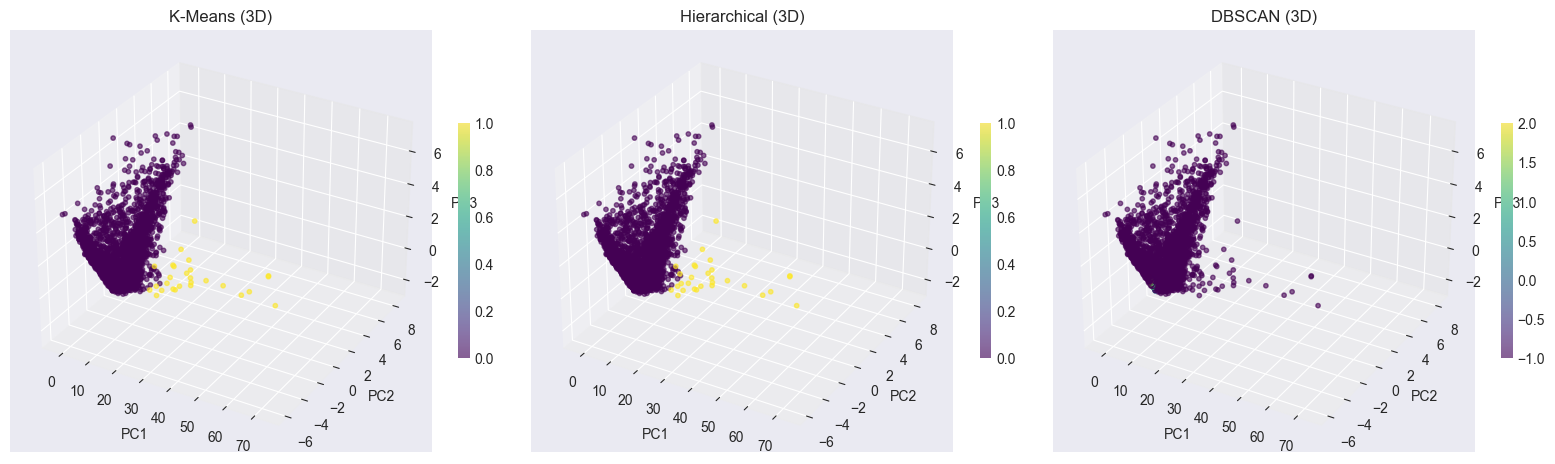

Total variance explained by 3 PCs: 79.78%


In [ ]:
# 3D Visualization
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

fig = plt.figure(figsize=(16, 5))

# K-Means 3D
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                       c=df_clean['Cluster_KMeans'], cmap='viridis', alpha=0.6, s=10)
ax1.set_title('K-Means (3D)')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
plt.colorbar(scatter1, ax=ax1, shrink=0.5)

# Hierarchical 3D
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                       c=df_clean['Cluster_Hierarchical'], cmap='viridis', alpha=0.6, s=10)
ax2.set_title('Hierarchical (3D)')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
plt.colorbar(scatter2, ax=ax2, shrink=0.5)

# DBSCAN 3D
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                       c=df_clean['Cluster_DBSCAN'], cmap='viridis', alpha=0.6, s=10)
ax3.set_title('DBSCAN (3D)')
ax3.set_xlabel('PC1')
ax3.set_ylabel('PC2')
ax3.set_zlabel('PC3')
plt.colorbar(scatter3, ax=ax3, shrink=0.5)

plt.tight_layout()
plt.show()

print(f"Total variance explained by 3 PCs: {pca_3d.explained_variance_ratio_.sum():.2%}")

<Figure size 1200x1000 with 0 Axes>

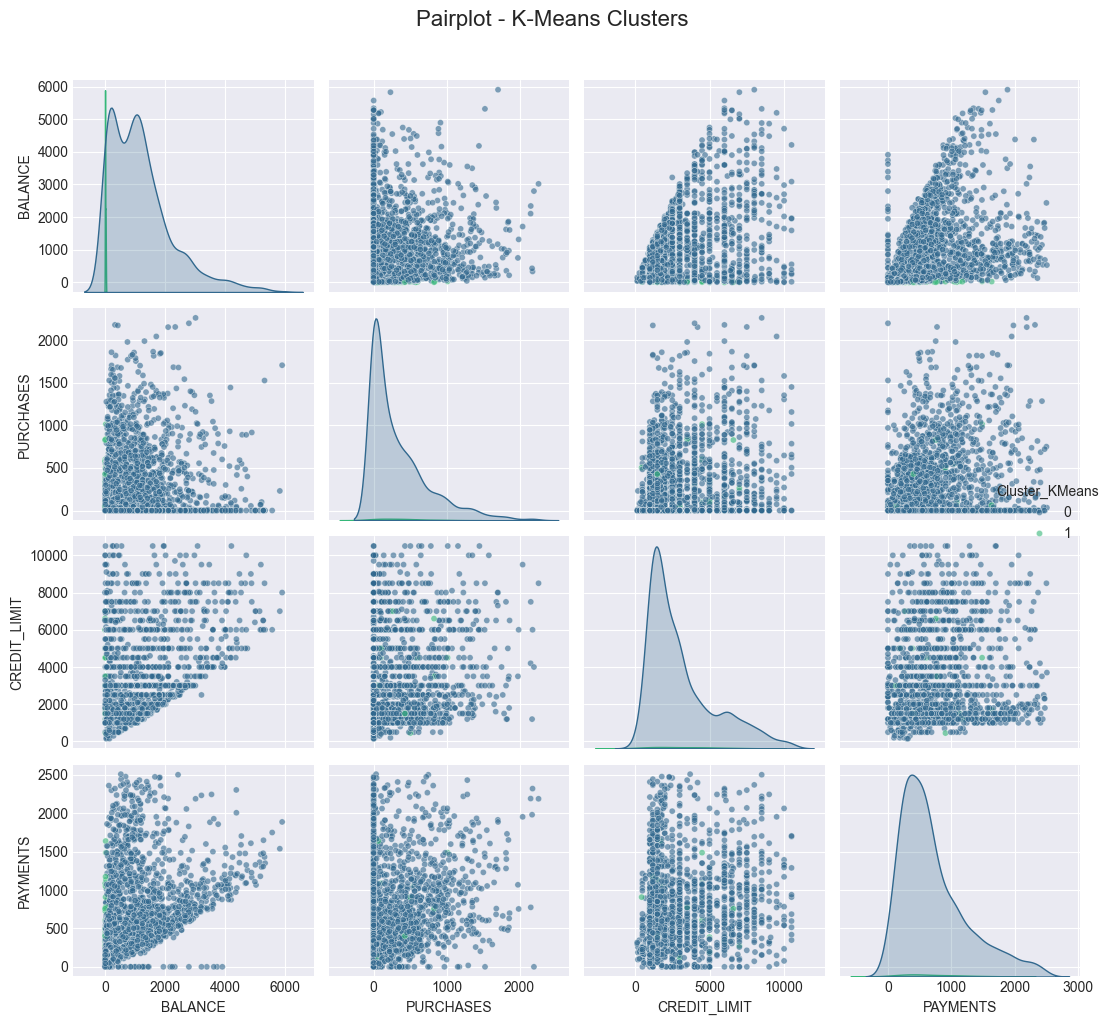

In [ ]:
# Pairplot untuk fitur penting (K-Means)
import seaborn as sns

# Pilih fitur penting dan sample data
important_features = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS']
sample_size = 2000
sample_idx = np.random.choice(len(df_clean), min(sample_size, len(df_clean)), replace=False)

df_sample = df_clean.iloc[sample_idx][important_features + ['Cluster_KMeans']].copy()

# Pairplot
plt.figure(figsize=(12, 10))
pairplot = sns.pairplot(df_sample, hue='Cluster_KMeans', palette='viridis', 
                        plot_kws={'alpha': 0.6, 's': 20}, diag_kind='kde')
pairplot.fig.suptitle('Pairplot - K-Means Clusters', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

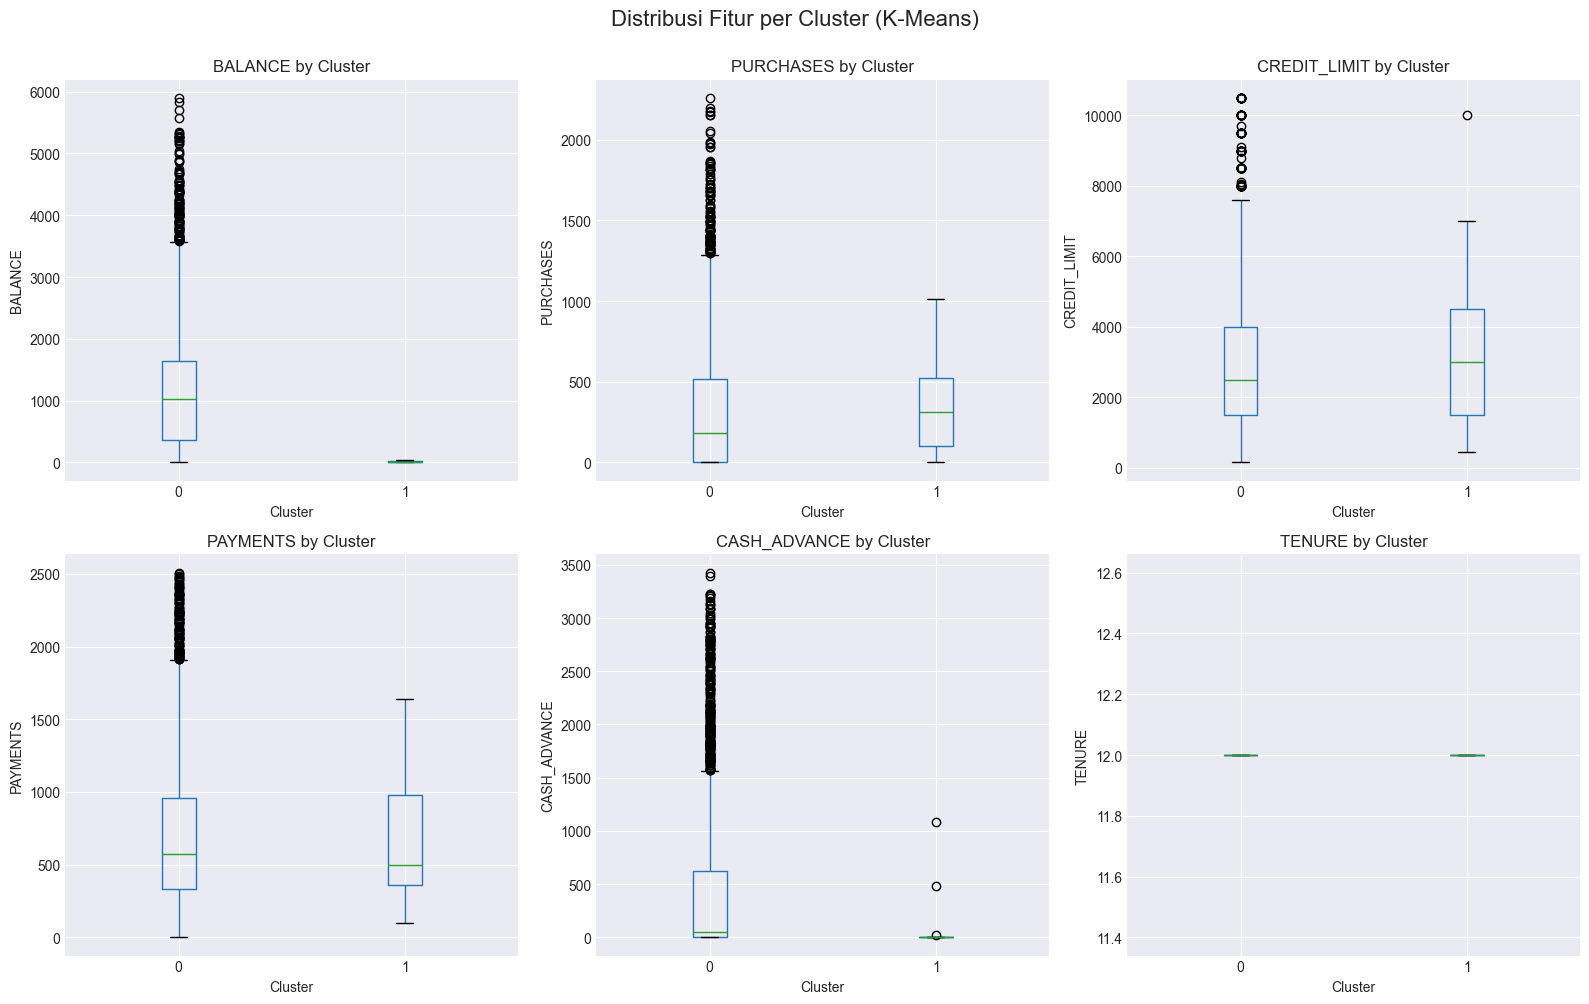

In [ ]:
# Boxplot distribusi fitur per cluster
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

features_box = ['BALANCE', 'PURCHASES', 'CREDIT_LIMIT', 'PAYMENTS', 'CASH_ADVANCE', 'TENURE']

for idx, feature in enumerate(features_box):
    df_clean.boxplot(column=feature, by='Cluster_KMeans', ax=axes[idx])
    axes[idx].set_title(f'{feature} by Cluster')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(feature)
    axes[idx].get_figure().suptitle('')

plt.suptitle('Distribusi Fitur per Cluster (K-Means)', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

## 11. Perbandingan Model


Perbandingan Model:
       Model  Silhouette  Davies-Bouldin  Calinski-Harabasz
     K-Means    0.495528        0.820398         771.788420
Hierarchical    0.802227        0.525428         768.287008


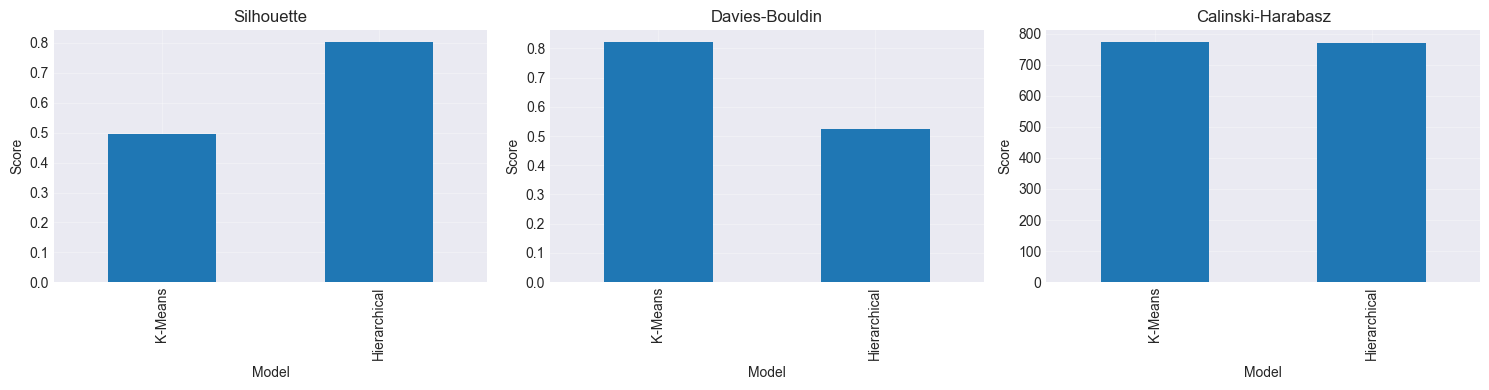

In [158]:
# Perbandingan metrik
comparison = pd.DataFrame({
    'Model': ['K-Means', 'Hierarchical'],
    'Silhouette': [sil_score, sil_score_h],
    'Davies-Bouldin': [db_score, db_score_h],
    'Calinski-Harabasz': [ch_score, ch_score_h]
})

print("\nPerbandingan Model:")
print(comparison.to_string(index=False))

# Visualisasi
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics = ['Silhouette', 'Davies-Bouldin', 'Calinski-Harabasz']
for idx, metric in enumerate(metrics):
    comparison.plot(x='Model', y=metric, kind='bar', ax=axes[idx], legend=False)
    axes[idx].set_title(metric)
    axes[idx].set_ylabel('Score')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()